In [95]:
import pandas as pd   
import numpy as np              
import pickle
import time

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from matplotlib import pyplot as plt

# Display inline plots as vector-based (svg)
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

In [96]:
df = pd.read_csv('fetal_health.csv')
na_counts = df.isna().sum()
print(na_counts)

df.head()

baseline value                                            0
accelerations                                             0
fetal_movement                                            0
uterine_contractions                                      0
light_decelerations                                       0
severe_decelerations                                      0
prolongued_decelerations                                  0
abnormal_short_term_variability                           0
mean_value_of_short_term_variability                      0
percentage_of_time_with_abnormal_long_term_variability    0
mean_value_of_long_term_variability                       0
histogram_width                                           0
histogram_min                                             0
histogram_max                                             0
histogram_number_of_peaks                                 0
histogram_number_of_zeroes                                0
histogram_mode                          

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [97]:
# Check data imbalance
df['fetal_health'].value_counts(normalize=True)

fetal_health
1.0    0.778457
2.0    0.138758
3.0    0.082785
Name: proportion, dtype: float64

In [98]:
X = df.drop(columns='fetal_health')
y = df['fetal_health']

# Convert fetat_health to str
y = y.astype(str)

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0) 

In [99]:
# Create functions
def get_classification_report(model_y_pred, file_name):
  report = classification_report(test_y, model_y_pred, output_dict = True)
  report_df = pd.DataFrame(report)
  display(report_df)
    
  report_df.to_csv(file_name)

  return report_df

def get_and_plot_confusion_matrix(model_y_pred, model, file_name):
  cm = confusion_matrix(test_y, model_y_pred, labels = model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)

  fig, ax = plt.subplots(figsize = (5, 5))
  plt.rcParams.update({'font.size': 12})
  disp.plot(cmap = 'Blues', ax = ax)
  fig.savefig(file_name, bbox_inches = 'tight')

  return cm

def get_and_plot_feature_importance(model, file_name):
  importance = model.feature_importances_
  feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)), columns = ['Feature', 'Importance'])
  feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

  plt.figure(figsize=(10, 5))
  plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['lightgrey', 'skyblue'])
  plt.xlabel('Importance')
  plt.title('Feature Importance for Fetal Health Predictions') 
  plt.tight_layout()
  plt.savefig(file_name)

  return feature_imp

In [100]:
dt_clf = DecisionTreeClassifier(random_state=0)
dt_clf.fit(train_X, train_y)
y_pred_dt = dt_clf.predict(test_X)

In [101]:
hyper_params = {'max_depth': [10, 20, 30, 40],
                'min_samples_split': [20, 40, 60],
                'min_samples_leaf': [10, 20, 30, 40, 100]}

folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

model_cv = GridSearchCV(estimator = dt_clf,
                        param_grid = hyper_params,
                        scoring = 'f1_weighted',
                        cv = folds,
                        verbose = 1,
                        n_jobs = -1) 

In [102]:
start = time.time()           
model_cv.fit(train_X, train_y)
stop = time.time()             
print(f"Training time: {stop - start}s")

print('Initial score: ', model_cv.best_score_)
print('Initial parameters: ', model_cv.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Training time: 0.6542019844055176s
Initial score:  0.916424666934238
Initial parameters:  {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 20}


In [103]:
# Tune hyperparamters
hyper_params_new = {
    'max_depth': list(range(2, 12)),
    'min_samples_split': list(range(15, 24)),
    'min_samples_leaf': list(range(2, 12))
}

# Call GridSearchCV()
model_cv = GridSearchCV(estimator = dt_clf,
                        param_grid = hyper_params_new,
                        scoring= 'f1_weighted',
                        cv = folds,
                        refit=True,
                        verbose = 1,
                        n_jobs = -1) # Will utilize all available CPUs

In [104]:
# Fit tuned model
start = time.time()      
model_cv.fit(train_X, train_y)
stop = time.time()           
print(f"Training time: {stop - start}s")

print('Improved score: ', model_cv.best_score_)
print('Improved parameters: ', model_cv.best_params_)

best_dt_clf = model_cv.best_estimator_

y_pred_best_dt_clf = best_dt_clf.predict(test_X)

Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Training time: 4.2974162101745605s
Improved score:  0.9212288545713442
Improved parameters:  {'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 15}


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


,1.0,2.0,3.0,accuracy,macro avg,weighted avg
precision,0.940299,0.816327,0.904762,0.922535,0.887129,0.919916
recall,0.966258,0.689655,0.904762,0.922535,0.853558,0.922535
f1-score,0.953101,0.747664,0.904762,0.922535,0.868509,0.920365
support,326.000000,58.000000,42.000000,0.922535,426.000000,426.000000


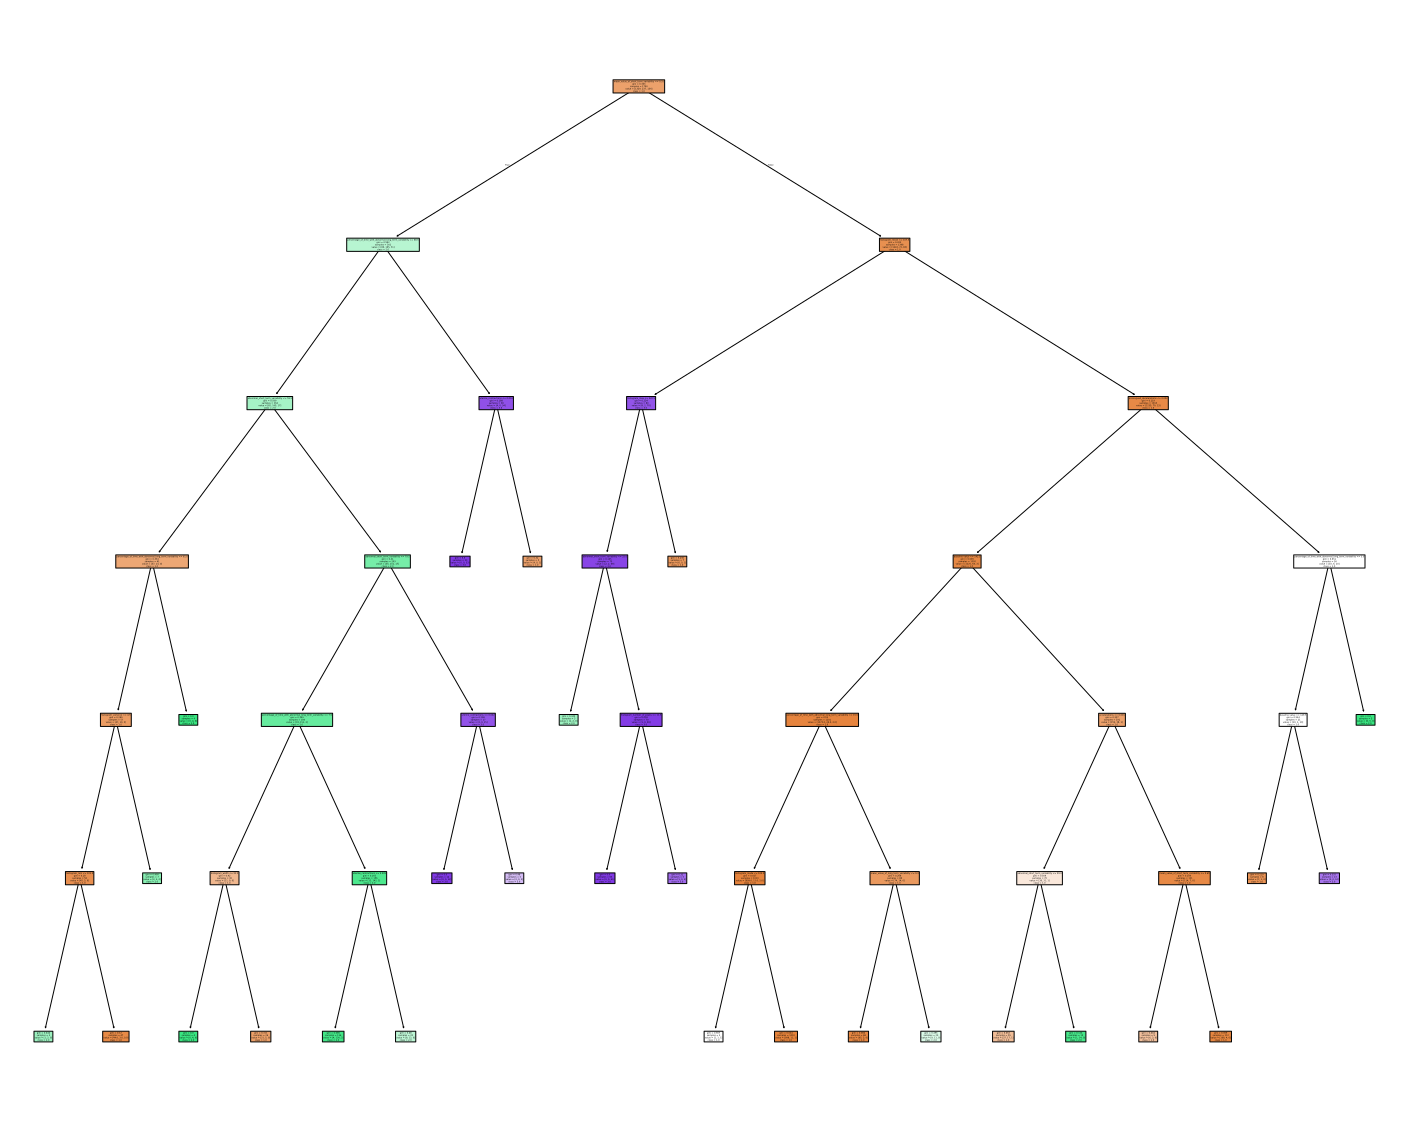

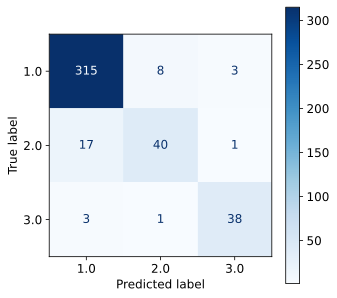

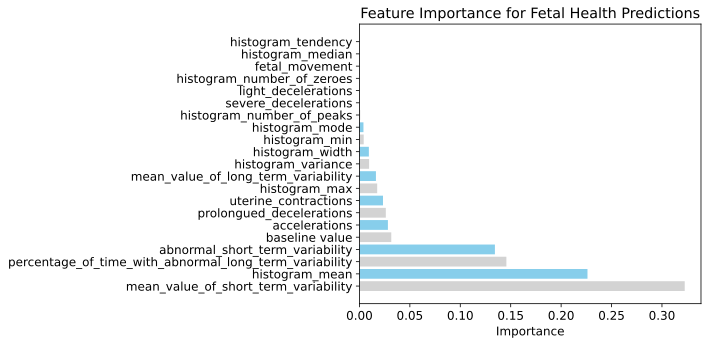

In [105]:
fig = plt.figure(figsize = (25,20))
a = tree.plot_tree(decision_tree = best_dt_clf,
                   max_depth = None,
                   feature_names = train_X.columns,
                   class_names = best_dt_clf.classes_,
                   filled = True)

# Saving Decision Tree
fig.savefig("image_dt.svg", bbox_inches = 'tight')

# Get classification report
dt_classification_df = get_classification_report(y_pred_best_dt_clf, 'class_report_dt.csv')

# Get confusion matrix
dt_cm = get_and_plot_confusion_matrix(y_pred_best_dt_clf, best_dt_clf, 'confusion_mat_dt.svg')

# Get feature importance
dt_feature_imp_df = get_and_plot_feature_importance(best_dt_clf, 'feat_imp_dt.svg')

In [106]:
# Get pickle
tree_pickle = open('decision_tree.pickle', 'wb') 
pickle.dump(best_dt_clf, tree_pickle) 
tree_pickle.close() 

In [107]:
rnd_forest_clf = RandomForestClassifier(max_depth=None, random_state=0)
rnd_forest_clf.fit(train_X, train_y)
y_pred_rnd_forest = rnd_forest_clf.predict(test_X)

In [108]:
hyper_params = {'max_depth': [10, 20, 30, 40],
                'min_samples_split': [20, 40, 60],
                'min_samples_leaf': [10, 20, 30, 40, 100]}

folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

model_cv = GridSearchCV(estimator = rnd_forest_clf,
                        param_grid = hyper_params,
                        scoring = 'f1_weighted',
                        cv = folds,
                        verbose = 1,
                        n_jobs = -1) 

In [109]:
start = time.time()           
model_cv.fit(train_X, train_y)
stop = time.time()             
print(f"Training time: {stop - start}s")

print('Initial score: ', model_cv.best_score_)
print('Initial parameters: ', model_cv.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Training time: 4.087256193161011s
Initial score:  0.9102029437252416
Initial parameters:  {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 20}


In [110]:
# Tune hyperparamters
hyper_params_new = {
    'max_depth': list(range(2, 12)),
    'min_samples_split': list(range(15, 24)),
    'min_samples_leaf': list(range(2, 12))
}

# Call GridSearchCV()
model_cv = GridSearchCV(estimator = rnd_forest_clf,
                        param_grid = hyper_params_new,
                        scoring= 'f1_weighted',
                        cv = folds,
                        refit=True,
                        verbose = 1,
                        n_jobs = -1) # Will utilize all available CPUs

In [111]:
# Fit tuned model
start = time.time()      
model_cv.fit(train_X, train_y)
stop = time.time()           
print(f"Training time: {stop - start}s")

print('Improved score: ', model_cv.best_score_)
print('Improved parameters: ', model_cv.best_params_)

best_rnd_forest_clf = model_cv.best_estimator_

y_pred_best_rnd_forest_clf = best_rnd_forest_clf.predict(test_X)

Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Training time: 63.701802253723145s
Improved score:  0.9310080295298212
Improved parameters:  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 15}


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [112]:
# Get pickle
rnd_forest_pickle = open('rnd_forest.pickle', 'wb') 
pickle.dump(rnd_forest_clf, rnd_forest_pickle) 
rnd_forest_pickle.close()

,1.0,2.0,3.0,accuracy,macro avg,weighted avg
precision,0.938596,0.847826,0.973684,0.931925,0.920036,0.929697
recall,0.984663,0.672414,0.880952,0.931925,0.846010,0.931925
f1-score,0.961078,0.750000,0.925000,0.931925,0.878693,0.928783
support,326.000000,58.000000,42.000000,0.931925,426.000000,426.000000


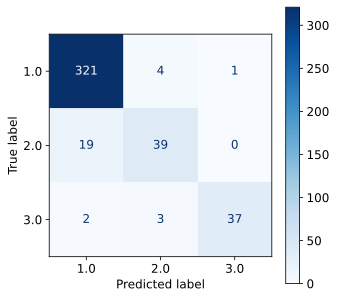

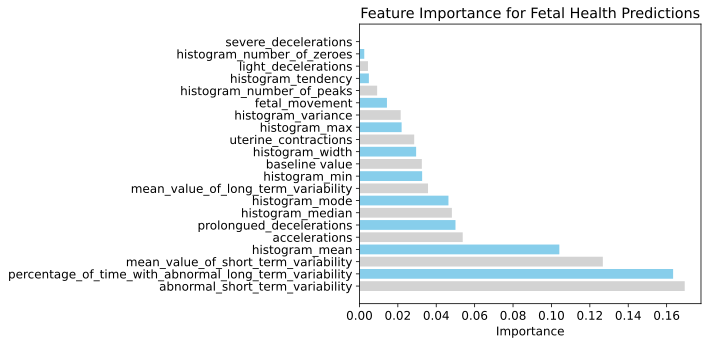

In [113]:

# Get classification report
rnd_forest_classification_df = get_classification_report(y_pred_best_rnd_forest_clf, 'class_report_rnd_forest.csv')

# Get confusion matrix
rnd_forest_cm = get_and_plot_confusion_matrix(y_pred_best_rnd_forest_clf, best_rnd_forest_clf, 'confusion_mat_rnd_forest.svg')

# Get feature importance
rnd_forest_feature_imp_df = get_and_plot_feature_importance(best_rnd_forest_clf, 'feat_imp_rnd_forest.svg')

In [114]:
base_estimator = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(estimator=base_estimator, random_state=0)

ada_clf.fit(train_X, train_y)
y_pred_ada_clf = ada_clf.predict(test_X)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [115]:
hyper_params = {'estimator__min_samples_leaf': [10, 20, 30, 40, 100],
                'estimator__max_depth': [5,10,13,15],
                'n_estimators': [50, 100, 150]}

folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

model_cv = GridSearchCV(estimator = ada_clf,
                        param_grid = hyper_params,
                        scoring = 'f1_weighted',
                        cv = folds,
                        verbose = 1,
                        n_jobs = -1) 

In [116]:
start = time.time()           
model_cv.fit(train_X, train_y)
stop = time.time()             
print(f"Training time: {stop - start}s")

print('Initial score: ', model_cv.best_score_)
print('Initial parameters: ', model_cv.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R

Training time: 22.890718936920166s
Initial score:  0.9362435158072584
Initial parameters:  {'estimator__max_depth': 5, 'estimator__min_samples_leaf': 10, 'n_estimators': 100}


In [117]:
# Tune hyperparamters
hyper_params_new = {'estimator__min_samples_leaf': list(range(2, 12)),
                    'estimator__max_depth': list(range(15, 24)),
                    'n_estimators': list(range(2, 12))}

# Call GridSearchCV()
model_cv = GridSearchCV(estimator = ada_clf,
                        param_grid = hyper_params_new,
                        scoring= 'f1_weighted',
                        cv = folds,
                        refit=True,
                        verbose = 1,
                        n_jobs = -1) # Will utilize all available CPUs

In [118]:
# Fit tuned model
start = time.time()      
model_cv.fit(train_X, train_y)
stop = time.time()           
print(f"Training time: {stop - start}s")

print('Improved score: ', model_cv.best_score_)
print('Improved parameters: ', model_cv.best_params_)

best_ada_clf = model_cv.best_estimator_

y_pred_best_adat_clf = best_ada_clf.predict(test_X)

Fitting 5 folds for each of 900 candidates, totalling 4500 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R

Training time: 35.67168188095093s
Improved score:  0.9445418181892542
Improved parameters:  {'estimator__max_depth': 17, 'estimator__min_samples_leaf': 2, 'n_estimators': 11}


,1.0,2.0,3.0,accuracy,macro avg,weighted avg
precision,0.94864,0.745455,0.900000,0.91784,0.864698,0.916181
recall,0.96319,0.706897,0.857143,0.91784,0.842410,0.917840
f1-score,0.95586,0.725664,0.878049,0.91784,0.853191,0.916847
support,326.00000,58.000000,42.000000,0.91784,426.000000,426.000000


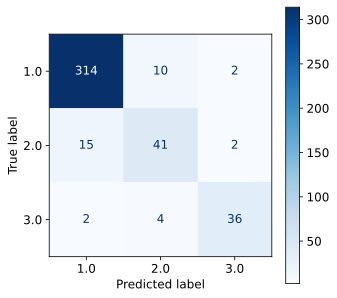

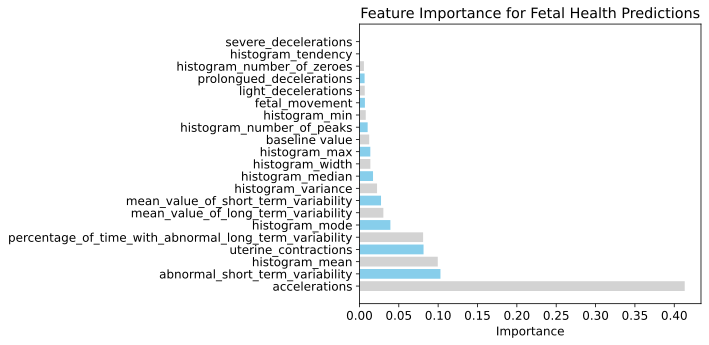

In [119]:

# Get classification report
ada_classification_df = get_classification_report(y_pred_ada_clf, 'class_report_ada.csv')

# Get confusion matrix
ada_cm = get_and_plot_confusion_matrix(y_pred_ada_clf, ada_clf, 'confusion_mat_ada.svg')

# Get feature importance
ada_feature_imp_df = get_and_plot_feature_importance(ada_clf, 'feat_imp_ada.svg')

In [120]:
# Get pickle
ada_pickle = open('ada.pickle', 'wb') 
pickle.dump(ada_clf, ada_pickle) 
ada_pickle.close()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


,1.0,2.0,3.0,accuracy,macro avg,weighted avg
precision,0.960961,0.849057,0.950000,0.946009,0.920006,0.944644
recall,0.981595,0.775862,0.904762,0.946009,0.887406,0.946009
f1-score,0.971168,0.810811,0.926829,0.946009,0.902936,0.944964
support,326.000000,58.000000,42.000000,0.946009,426.000000,426.000000


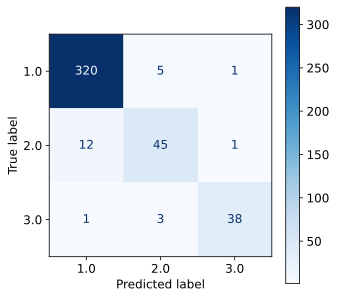

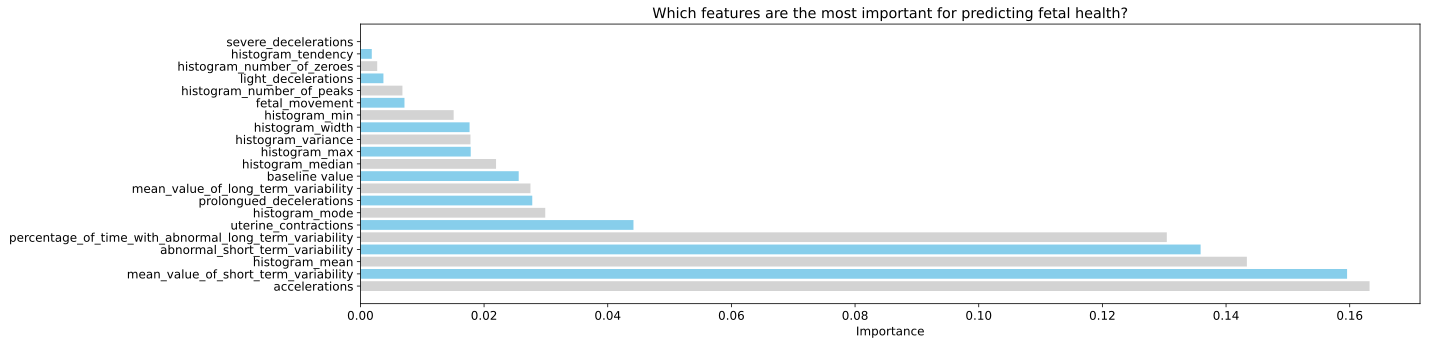

In [121]:
# Get f1 macro scores for each model
dt_macro_f1 = dt_classification_df['macro avg'].loc['f1-score']
rnd_forest_macro_f1 = rnd_forest_classification_df['macro avg'].loc['f1-score']
ada_macro_f1 = ada_classification_df['macro avg'].loc['f1-score']

macro_f1_sum = sum([dt_macro_f1, rnd_forest_macro_f1, ada_macro_f1])

# Normalize f1 macro scores
dt_macro_f1_norm = dt_macro_f1 / macro_f1_sum
rnd_forest_macro_f1_norm = rnd_forest_macro_f1 / macro_f1_sum
ada_macro_f1_norm = ada_macro_f1 / macro_f1_sum


sft_vt_clf = VotingClassifier(estimators=[
  ('dt', dt_clf),
  ('rnd_forest', rnd_forest_clf),
  ('ada', ada_clf)],
  weights=[dt_macro_f1_norm, rnd_forest_macro_f1_norm, ada_macro_f1_norm],
  voting='soft')

sft_vt_clf = sft_vt_clf.fit(train_X, train_y)
y_pred_sft_vt_clf = sft_vt_clf.predict(test_X)

sft_vt_classification_df = get_classification_report(y_pred_sft_vt_clf, 'class_report_sft_vt.csv')
sft_vt_cm = get_and_plot_confusion_matrix(y_pred_sft_vt_clf, sft_vt_clf, 'confusion_mat_sft_vt.svg')

# Rename columns
dt_feature_imp_df.rename(columns={'Importance': 'DecisionTree Importance'}, inplace=True)
rnd_forest_feature_imp_df.rename(columns={'Importance': 'RandomForest Importance'}, inplace=True)
ada_feature_imp_df.rename(columns={'Importance': 'AdaBoost Importance'}, inplace=True)

# Merge feature importance dataframes
aggregated_feature_imp_df = dt_feature_imp_df.merge(rnd_forest_feature_imp_df, on='Feature')
aggregated_feature_imp_df = aggregated_feature_imp_df.merge(ada_feature_imp_df, on='Feature')

# Calculate weighted importance
dt_weighted = aggregated_feature_imp_df['DecisionTree Importance'] * dt_macro_f1_norm
rf_weighted = aggregated_feature_imp_df['RandomForest Importance'] * rnd_forest_macro_f1_norm
ada_weighted = aggregated_feature_imp_df['AdaBoost Importance'] * ada_macro_f1_norm

aggregated_feature_imp_df['Weighted Importance'] = dt_weighted + rf_weighted + ada_weighted
aggregated_feature_imp_df = aggregated_feature_imp_df.sort_values('Weighted Importance', ascending = False).reset_index(drop = True)

# Plot
plt.figure(figsize=(20, 5))
plt.barh(aggregated_feature_imp_df['Feature'], aggregated_feature_imp_df['Weighted Importance'], color = ['lightgrey', 'skyblue'])
plt.xlabel('Importance')
plt.title('Which features are the most important for predicting fetal health?') 
plt.tight_layout()
plt.savefig('feat_imp_sft_vt.svg')

In [122]:
# Get pickle
sft_vt_pickle = open('soft_voting.pickle', 'wb') 
pickle.dump(sft_vt_clf, sft_vt_pickle) 
sft_vt_pickle.close()